**Objective:**

This deliverable implements a fully connected deep neural network (DNN) for multi-class speech emotion recognition. Short speech utterances from the RAVDESS dataset are classified into eight emotions—Neutral, Calm, Happy, Sad, Angry, Fearful, Disgust, and Surprised—using raw audio inputs without manual feature engineering.

The DNN learns hierarchical representations directly from the input signals, enabling the model to automatically extract discriminative features for classification. Performance is evaluated using metrics such as accuracy and F1-score, providing a deep learning baseline for comparison with classical ML models and sequence-based networks in later phases.

**Dataset Description**

**Dataset Name & Source:**

RAVDESS (Ryerson Audio-Visual Database of Emotional Speech and Song) is a public academic dataset available via Zenodo/Kaggle.

**Nature of Data:**

The dataset contains audio speech recordings in WAV format representing human emotions. Audio is recorded at 48 kHz, mono channel, with an average duration of about 3 seconds per sample. For machine learning, audio signals are converted into numerical features (e.g., MFCCs), resulting in tabular data.

**Size & Features:**

The dataset includes 1,440 speech samples recorded by 24 professional actors (12 male, 12 female). After feature extraction, each sample is represented by a set of numerical features (exact number depends on the feature-engineering method used).

**Target Variable:**

The target variable is Emotion, consisting of 8 classes:
Neutral, Calm, Happy, Sad, Angry, Fearful, Disgust, and Surprised.

**Metadata & Quality:**

File names encode emotion label, intensity, and actor information. Recordings are collected in controlled studio conditions with no missing values in raw audio. The dataset is high quality but contains acted emotions and slight class imbalance. Preprocessing such as normalization, feature extraction, and feature scaling is required.

**Feature Engineering / Preprocessing**

Since the attributes within the dataset are audio (sequential time series) signals, the following tasks I carried out for preprocessing/feature creation:

**Audio Loading & Standardization:**

Every audio file of speech was loaded with a fixed target sampling rate. The audio samples were either zero-padded or truncated to a fixed length. This is because all samples should have the same uniform length.

**Feature Extraction:**

Mel-Frequency Cepstral Coefficients (MFCCs) were obtained for each audio signal, as they are adequate for capturing the properties of human voices with respect to expressing emotions. The mean of MFCC values over time was calculated to obtain fixed-size vectors from the variable-size MFCCs.

**Label Extraction:**

The emotion labels used were derived from the RAVDESS naming convention and corresponding to the following emotion categories: neutral, calm, happy, sad, angry, fearful, disgust, surprised. Feature Scaling: Since MFCC features are numeric values, and classical machine learning models are sensitive to scaling, a standardization preprocess (z-normalization) has been performed on the MFCC features using StandardScaler, which leads to zero-mean unit-variance features. Missing values & data quality: The resulting feature vectors were free from missing values. Additionally, because of the controlled recording environment, the effect of noise on the signals was minimal, eliminating the need to clean them. Final dataset representation: The preprocessing step results in a fixed-size, scaled numeric feature vector for each audio clip that is compatible with ML for use in classical machine learning classification models.

**Class Distribution**


In [ ]:
import pandas as pd

# Create DataFrame
df = pd.DataFrame({
    "Emotion_Label": labels
})

# Map numeric labels to emotion names (RAVDESS)
emotion_map = {
    1: "Neutral",
    2: "Calm",
    3: "Happy",
    4: "Sad",
    5: "Angry",
    6: "Fearful",
    7: "Disgust",
    8: "Surprised"
}

df["Emotion"] = df["Emotion_Label"].map(emotion_map)

# Count samples per class
class_distribution = df["Emotion"].value_counts().sort_index()

print("Class Distribution:\n")
print(class_distribution)


Class Distribution:

Emotion
Angry        384
Calm         384
Disgust      384
Fearful      384
Happy        384
Neutral      192
Sad          384
Surprised    384
Name: count, dtype: int64


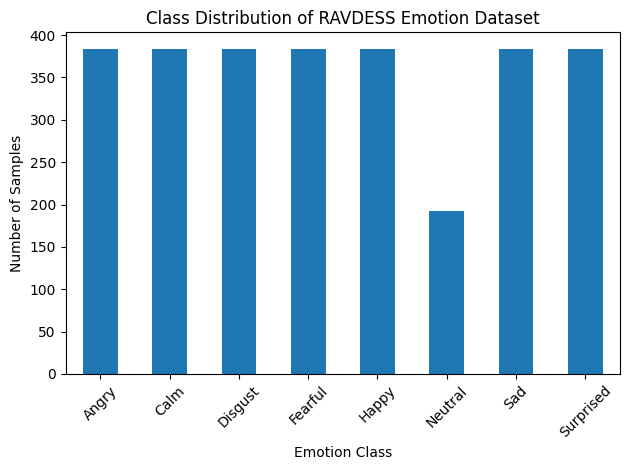

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
class_distribution.plot(kind='bar')
plt.xlabel("Emotion Class")
plt.ylabel("Number of Samples")
plt.title("Class Distribution of RAVDESS Emotion Dataset")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Preprocessing Data And Splitting Into Train And Test**

In [1]:
TARGET_SR = 16000
FIXED_DURATION = 3.0
FEATURE_TYPE = "mel"
N_MELS = 128
N_MFCC = 40

In [2]:
!pip install -q librosa soundfile kaggle tqdm

In [3]:
import os
import shutil
import zipfile
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
import librosa
import soundfile as sf

In [4]:
!pip install kaggle
from google.colab import files
files.upload()
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio --unzip -p /content/ravdess
!ls '/content/ravdess'

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
License(s): CC-BY-NC-SA-4.0
 95% 408M/429M [00:02<00:00, 155MB/s] 
100% 429M/429M [00:02<00:00, 156MB/s]
Actor_01  Actor_06  Actor_11  Actor_16	Actor_21
Actor_02  Actor_07  Actor_12  Actor_17	Actor_22
Actor_03  Actor_08  Actor_13  Actor_18	Actor_23
Actor_04  Actor_09  Actor_14  Actor_19	Actor_24
Actor_05  Actor_10  Actor_15  Actor_20	audio_speech_actors_01-24


In [5]:
from pathlib import Path
AUDIO_ROOT = Path("/content/ravdess")
speech_wavs = sorted([p for p in AUDIO_ROOT.rglob('*.wav') if p.name.startswith('03-01-')])
print(f"Total speech audio-only files found: {len(speech_wavs)}")
print("First 5 files:")
for f in speech_wavs[:5]:
    print(f)

Total speech audio-only files found: 2880
First 5 files:
/content/ravdess/Actor_01/03-01-01-01-01-01-01.wav
/content/ravdess/Actor_01/03-01-01-01-01-02-01.wav
/content/ravdess/Actor_01/03-01-01-01-02-01-01.wav
/content/ravdess/Actor_01/03-01-01-01-02-02-01.wav
/content/ravdess/Actor_01/03-01-02-01-01-01-01.wav


In [6]:
import librosa
import numpy as np
from sklearn.preprocessing import StandardScaler
features = []
labels = []
max_len = int(TARGET_SR * FIXED_DURATION)
print("Extracting MFCC features...")
for wav_path in tqdm(speech_wavs):
    y, sr = librosa.load(wav_path, sr=TARGET_SR)
    if len(y) < max_len:
        y = np.pad(y, (0, max_len - len(y)))
    else:
        y = y[:max_len]
    mfccs = librosa.feature.mfcc(y=y, sr=TARGET_SR, n_mfcc=N_MFCC)
    mfccs_mean = np.mean(mfccs.T, axis=0)
    features.append(mfccs_mean)
    emotion_code = int(wav_path.name.split('-')[2])
    labels.append(emotion_code)

features = np.array(features)
labels = np.array(labels)
print("Features shape:", features.shape)
print("Labels shape:", labels.shape)

Extracting MFCC features...


100%|██████████| 2880/2880 [01:05<00:00, 43.86it/s]

Features shape: (2880, 40)
Labels shape: (2880,)


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    features,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)


In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [9]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_test_enc = encoder.transform(y_test)

num_classes = len(np.unique(y_train_enc))

y_train_cat = to_categorical(y_train_enc, num_classes)
y_test_cat = to_categorical(y_test_enc, num_classes)


In [11]:
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

model = Sequential()

model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# COMPILE MODEL
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# TRAIN MODEL
history = model.fit(
    X_train,
    y_train_cat,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# EVALUATION
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

accuracy = accuracy_score(y_test_enc, y_pred)
f1 = f1_score(y_test_enc, y_pred, average='macro')

print("Accuracy:", accuracy)
print("F1-Score:", f1)


Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.1993 - loss: 1.9909 - val_accuracy: 0.4013 - val_loss: 1.6677
Epoch 2/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3950 - loss: 1.6375 - val_accuracy: 0.4946 - val_loss: 1.4447
Epoch 3/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4485 - loss: 1.4477 - val_accuracy: 0.4664 - val_loss: 1.3457
Epoch 4/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5444 - loss: 1.2741 - val_accuracy: 0.5727 - val_loss: 1.1674
Epoch 5/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5848 - loss: 1.1378 - val_accuracy: 0.6117 - val_loss: 1.0586
Epoch 6/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6439 - loss: 1.0042 - val_accuracy: 0.6226 - val_loss: 1.0130
Epoch 7/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6823 - loss: 0.9177 - val_accuracy: 0.6833 - val_loss: 0.9247
Epoch 8/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7007 - loss: 0.8427 - val_accuracy: 0.7223 - val_loss: 0.8327
Epo

In [23]:
from IPython.display import Audio, display
import librosa

idx = 250  # choose any index

# Load audio
y, sr = librosa.load(speech_wavs[idx], sr=None)

# Display label
print("Label (Emotion Code):", labels[idx])

# Play audio
display(Audio(y, rate=sr))


# 1: "Neutral",
#     2: "Calm",
#     3: "Happy",
#     4: "Sad",
#     5: "Angry",
#     6: "Fearful",
#     7: "Disgust",
#     8: "Surprised"

Label (Emotion Code): 2


In [31]:
from google.colab import files

uploaded = files.upload()
import librosa
import numpy as np

def preprocess_audio(file_path, target_sr, fixed_duration, n_mfcc):
    max_len = int(target_sr * fixed_duration)

    y, sr = librosa.load(file_path, sr=target_sr)

    if len(y) < max_len:
        y = np.pad(y, (0, max_len - len(y)))
    else:
        y = y[:max_len]

    mfccs = librosa.feature.mfcc(y=y, sr=target_sr, n_mfcc=n_mfcc)
    mfccs_mean = np.mean(mfccs.T, axis=0)

    return mfccs_mean
sample_features = preprocess_audio(
    file_path="surprise.wav",
    target_sr=TARGET_SR,
    fixed_duration=FIXED_DURATION,
    n_mfcc=N_MFCC
)
sample_features = scaler.transform(sample_features.reshape(1, -1))
pred_prob = model.predict(sample_features)
pred_class = np.argmax(pred_prob, axis=1)[0]
emotion_map = {
    0: "Neutral",
    1: "Calm",
    2: "Happy",
    3: "Sad",
    4: "Angry",
    5: "Fearful",
    6: "Disgust",
    7: "Surprised"
}

print("Predicted Emotion:", emotion_map[pred_class])


Saving surprise.wav to surprise.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predicted Emotion: Fearful


In [30]:
from IPython.display import Audio, display

y, sr = librosa.load("fear.wav", sr=None)
display(Audio(y, rate=sr))
